In [ ]:
#Install the necessary packages

!pip install yfinance
!pip install matplotlib==3.5.3

In [3]:
#Standard packages
import numpy as np
import pandas as pd

#Dates
from datetime import datetime, timedelta

#Finance packages
import yfinance as yf

#Statistics
from scipy.stats import binom

#Plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import rcParams

rcParams["font.size"] = 20
rcParams["axes.labelsize"] = 30

rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

rcParams["figure.figsize"] = (8,6)

A financial option is a contract between a buyer and a seller that gives the buyer the right, but not the obligation, to buy or sell an underlying asset, such as a stock, at a specific price (**strike price**, $K$) on or before a specific date (**expiration date**, $T$). The seller, or option writer, is obligated to fulfill the terms of the contract if the buyer chooses to exercise their option. Options can be used for a variety of purposes, such as hedging risk or speculating on the price movement of an asset. There are two main types of options: **call** options, which give the buyer the right to buy the underlying asset, and **put** options, which give the buyer the right to sell the underlying asset. The options are buyed at a given price, $C_0$.

There are different types of options with different obligations, but we will focus on the European ones, which can only be executed at the expiration date.

Mathematically, we can evaluate the payoff of an (european) option at the expiration date $T$ as function of the value of the underlying asset at that moment, $Y(T)$, the strike price $K$ and the initial price, $C_0$.

The payoff of a call option is the difference between the price of the underlying asset and the strike price of the option

$$P_c(Y,T) = max(Y(T) - K - C_0, -C_0)$$

The payoff of a put option is the difference between the strike price of the option and the price of the underlying asset

$$P_p(Y,T) = max(K - Y(T)-C_0, -C_0)$$

It's important to note that these payoffs are only realized if the option is exercised and the underlying asset is bought or sold at the strike price. Also, the above equations are for European Options, so for other options the payoffs can be different.

#The binomial model

The binomial option pricing model is a mathematical model that is used to determine the *fair value* of an option. It is based on the idea that the underlying asset can move to one of two possible states (up or down) at the end of each time period. The model uses a recursive algorithm to calculate the value of the option at each point in time, taking into account the probability of the underlying asset moving up or down and the resulting payoffs from the option. In this model, the fair price of the option after a time $t=N\Delta t$ (so $N$ steps) is given by

$$C_0=e^{-rt}\sum_{k=0}^N\left(\begin{array}{c}N \\
K\end{array}\right)p_e^k\left(1-p_e\right)^{N-k}max(u^kd^{N-k}Y_0-K, 0)$$

with $p_e=\frac{e^{r\Delta t}-d}{u-d}$ and $u, d$ being the factor in which the price of the option can change *up* or *down*, respectively.

Indeed, a closed equation for the *fair price* of the option after $N$ steps can be found in terms of the cumulative distribution function of the binomial distribution, $F(x; N, p)$,

$$C_0=Y_0F(N-a, N, q_e')- e^{-rt}KF(N-a, N, q_e)$$

where

* $a=\left\lceil\frac{\ln(K/Y_0d^N)}{\ln(u/d)}\right\rceil$ where $\lceil x\rceil$ is the ceil function, which returns the smallest integer $i$ such that $i\geq x$

* $q_e = 1-p_e$

* $q_e'=1-ue^{-r\Delta t}p_e$

* $F(N-a,N,q_e)$ is the cumulative distribution of the binomial

In practice, $u$ and $d$ are determined from the volatility of the underlying asset.

# Exercise 1. Option Pricing using the binomial model

1. Implement the binomial model for option pricing using the first of the formulas above

  * I give you the implementation of the second formula, the "analytical" one.

2. Compare your implementation to the analytical one by giving some values to the parameters and runing the functions.

3. Use the binomial model to price real options of BP.

  * Compare your predicted fair values of the options with the traded ones. Is there a correspondance?

4. Repeat the previous step now with options from Tesla

  * What do you observe? Why do you think this is happening?



**1. Complete the functions below to implement the binomial model for a call option.**

*Clue: use the `numpy.ceil()` method to obtain $a$*

*Clue: use the `scipy.stats.binom` function to compute the CDF of the binomiald distribution. The function is alrealy loaded as `binom`*

In [4]:
def comb(n, i): #Returns the result of n combined with i

    return np.math.factorial(n) / (np.math.factorial(n-i)*np.math.factorial(i))

def call_price_binomial_computational(N, Y0, K, r, dt, u, d):
  p_e = (np.exp(r*dt)-d)/(u-d)        # Define p_e
  C0 = 0
  for i in range(N+1):
    Dlt = comb(N,i)*p_e**i*(1-p_e)**(N-i)*max(u**i*d**(N-i)*Y0-K,0)
    C0 = C0 + Dlt
  #  print(u**i*d**(N-i)*Y0-K,i,N)
  C0 = C0*np.exp(-r*N*dt)
  return C0

def call_price_binomial_analytical(N, Y0, K, r, dt, u, d):
  a = np.ceil(np.log(K/(Y0*d**N))/np.log(u/d))
  p_e = (np.exp(r*dt)-d)/(u-d)
  q = 1 - p_e
  q_prime = 1-u*np.exp(-r*dt)*p_e
  C0 = Y0*binom.cdf(N-a,N,q_prime) - np.exp(-r*N*dt)*K*binom.cdf(N-a,N,q)
  return C0

**2. Compare computational and theoretical methods**

<ipython-input-4-c57471c892b9>:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(n) / (np.math.factorial(n-i)*np.math.factorial(i))


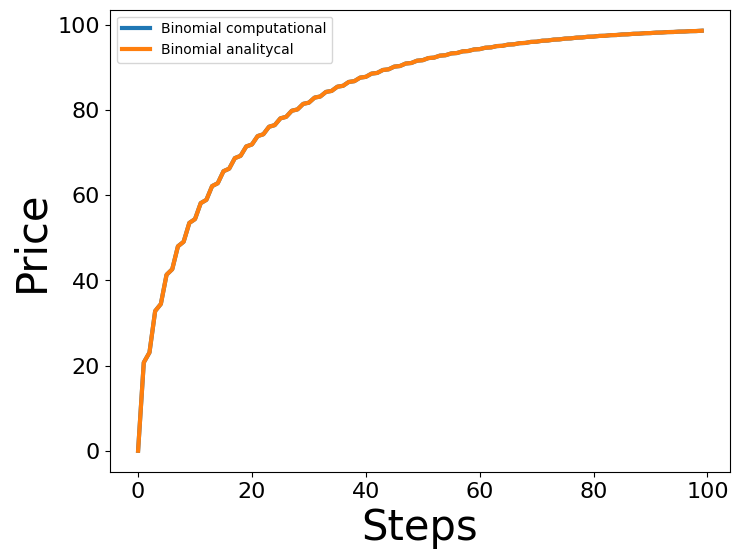

In [35]:
#Initial value of the underlying asset
Y0  = 100

#Volatility of the underlying asset
sigma = 0.5

#Strike price
K = 110

#Interest rate (zero for simplicity)
r = 0.0

#Time step
dt = 1

#Up and down price change factors
u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))
#Steps
steps = 100

#Compute the fair prices for each step (N from 0 to steps) using the computational and analytical methods
comp_prices = []
analy_prices = []
for N in range(steps):
  comp_prices.append(call_price_binomial_computational(N, Y0, K, r, dt, u, d))
  analy_prices.append(call_price_binomial_analytical(N, Y0, K, r, dt, u, d))


#Plot the prices according to both methods
plt.plot(comp_prices, lw=3,label="Binomial computational")
plt.plot(analy_prices, lw=3,label="Binomial analitycal")
plt.ylabel('Price')
plt.xlabel('Steps')
plt.legend()

plt.show()


In [ ]:
#No s'aprecia gaire bé, però les dues linies són iguales

**3. Price Real Options from BP**

Run the following cell to download the data.

**It will take a while to download, be patient.**

Then, price each **Call** option using the binomial model and compare the results with the real traded prices.

**Note that we download data for Call and Put options, but we only want to price the Call ones**

In [20]:
def options_data(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        # opt = pd.DataFrame().append(opt.calls).append(opt.puts) ## deprecated
        opt = pd.concat((opt.calls, opt.puts))
        opt['expirationDate'] = e
        # options = options.append(opt, ignore_index=True) ## deprecated
        options = pd.concat((options,opt), ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.today()).dt.days / 365

    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)

    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)

    # Drop unnecessary and meaningless columns
    #options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'bid', 'ask', 'inT'])
    options = options[["lastTradeDate", "strike", "lastPrice", "expirationDate", "impliedVolatility", "openInterest", "CALL"]]

    #Add underlying price of asset for each tradeDate
    print("Matching last traded dates with underlying prices... this might take a while...")

    underlying_prices = []

    tot = len(options)

    i = 0

    for date in options["lastTradeDate"]:

      pct = 100*i/tot

      if np.round((pct % 2), 2) == 0.0:

        print("Completed: %.2f %%" % pct)

      Y0 = yf.download(asset, start=date, end=date, progress=False, period="1d")["Adj Close"].values

      if len(Y0) == 0:

        underlying_prices.append(np.nan)

      else:

        underlying_prices.append(Y0[0])

      i += 1

    options["underlying_price"] = underlying_prices

    return options

asset = "BP"

df = options_data(asset)

df = df.dropna()

df["lastTradeDate"] = pd.to_datetime(df["lastTradeDate"])
df["expirationDate"] = pd.to_datetime(df["expirationDate"])

df

Matching last traded dates with underlying prices... this might take a while...
Completed: 0.00 %
Completed: 26.00 %


,lastTradeDate,strike,lastPrice,expirationDate,impliedVolatility,openInterest,CALL,underlying_price
0,2024-04-26 17:49:03+00:00,30.0,9.55,2024-05-11,0.000010,0,True,39.470001
1,2024-05-01 19:17:25+00:00,32.0,6.43,2024-05-11,0.000010,0,True,38.220001
2,2024-05-07 18:36:39+00:00,35.0,2.74,2024-05-11,0.000010,0,True,37.580002
3,2024-05-07 19:58:49+00:00,35.5,2.17,2024-05-11,0.000010,0,True,37.580002
4,2024-05-07 14:04:12+00:00,36.0,2.04,2024-05-11,0.000010,0,True,37.580002
...,...,...,...,...,...,...,...,...
468,2024-05-07 15:39:44+00:00,45.0,8.67,2026-01-17,0.000010,0,False,37.580002
469,2024-03-22 16:44:45+00:00,47.0,10.30,2026-01-17,0.156381,2201,False,37.799999
470,2024-04-25 16:54:23+00:00,50.0,11.41,2026-01-17,0.000010,0,False,39.619999
471,2024-04-30 19:52:17+00:00,55.0,16.72,2026-01-17,0.000010,0,False,38.770000


In [ ]:
df.info()

In [25]:
df = df.loc[df.CALL == True]
K = df['strike']
Y0 = df['underlying_price']
r =0# df['openInterest']
dt=1                              # in days

# We obtain the standard deviation of the asset from a period of 2 years
sigma =np.log(yf.download(asset, period="2y" , interval= "1d")['Adj Close'].pct_change()+1).std()

#Up and down price change factors
u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))
# Number of steps
steps =np.int64((df['expirationDate']- df['lastTradeDate'].dt.tz_convert(None))/timedelta(days=dt))

df['BinomPrice'] = call_price_binomial_analytical(steps, Y0, K, r, dt, u, d)
df.head()

[*********************100%%**********************]  1 of 1 completed


,lastTradeDate,strike,lastPrice,expirationDate,impliedVolatility,openInterest,CALL,underlying_price,BinomPrice
0,2024-04-26 17:49:03+00:00,30.0,9.55,2024-05-11,0.00001,0,True,39.470001,9.470001
1,2024-05-01 19:17:25+00:00,32.0,6.43,2024-05-11,0.00001,0,True,38.220001,6.220001
2,2024-05-07 18:36:39+00:00,35.0,2.74,2024-05-11,0.00001,0,True,37.580002,2.580002
3,2024-05-07 19:58:49+00:00,35.5,2.17,2024-05-11,0.00001,0,True,37.580002,2.080002
4,2024-05-07 14:04:12+00:00,36.0,2.04,2024-05-11,0.00001,0,True,37.580002,1.617267


<AxesSubplot:xlabel='BinomPrice', ylabel='lastPrice'>

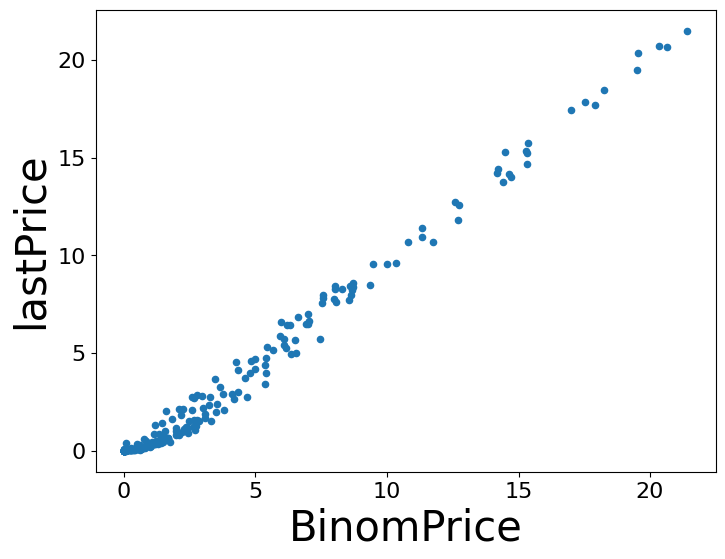

In [26]:
# Plotting the results, we should see a stright line

df.plot.scatter(x="BinomPrice" ,y="lastPrice" )

Veim com el preu de les opcions és molt semblant al preu que hem predit. Cosa que no es d'extranyar, ja que les opcions del mon real solen valorar-se amb mètodes semblants.

**4. Repeat the last step for options from Tesla**

*Note: Downloading these options is quite slow, as we have to match the original value of the asset for each traded date in our dataset and Tesla has many options being traded. Anyway, I did this for you so that you just need to load a CSV file*

In [27]:
df = pd.read_csv("/content/Options_TSLA.csv")

df = df.drop("Unnamed: 0", axis=1)
df = df.dropna()

df["lastTradeDate"] = pd.to_datetime(df["lastTradeDate"])
df["expirationDate"] = pd.to_datetime(df["expirationDate"])

df

,lastTradeDate,strike,lastPrice,expirationDate,impliedVolatility,openInterest,CALL,underlying_price
0,2023-01-12 20:41:36+00:00,1.67,121.50,2023-01-21,13.750001,606.0,True,123.559998
1,2023-01-12 20:41:48+00:00,3.33,119.90,2023-01-21,11.687503,431.0,True,123.559998
2,2023-01-12 20:37:07+00:00,5.00,118.10,2023-01-21,0.500005,811.0,True,123.559998
3,2023-01-12 20:44:21+00:00,6.67,116.50,2023-01-21,8.875004,559.0,True,123.559998
4,2023-01-12 20:41:48+00:00,8.33,114.90,2023-01-21,8.500005,597.0,True,123.559998
...,...,...,...,...,...,...,...,...
5201,2022-10-31 19:09:32+00:00,570.00,342.91,2025-01-18,0.000010,0.0,False,227.539993
5202,2022-12-21 15:19:46+00:00,580.00,440.55,2025-01-18,0.609989,0.0,False,137.570007
5203,2022-12-21 15:19:27+00:00,590.00,450.35,2025-01-18,0.614750,0.0,False,137.570007
5204,2023-01-04 17:56:05+00:00,600.00,488.00,2025-01-18,0.619389,0.0,False,113.639999


In [ ]:
df = df.loc[df.CALL == True]
K = df['strike']
Y0 = df['underlying_price']
r = 0 #df['openInterest']
dt=1                              # in days

sigma =np.log(yf.download(asset, period="2y" , interval= "1d")['Adj Close'].pct_change()+1).std()
#Up and down price change factors
u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))
# Number of steps
steps =np.int64((df['expirationDate']- df['lastTradeDate'].dt.tz_convert(None))/timedelta(days=dt))

df['BinomPrice'] = call_price_binomial_analytical(steps, Y0, K, r, dt, u, d)

<AxesSubplot:xlabel='BinomPrice', ylabel='lastPrice'>

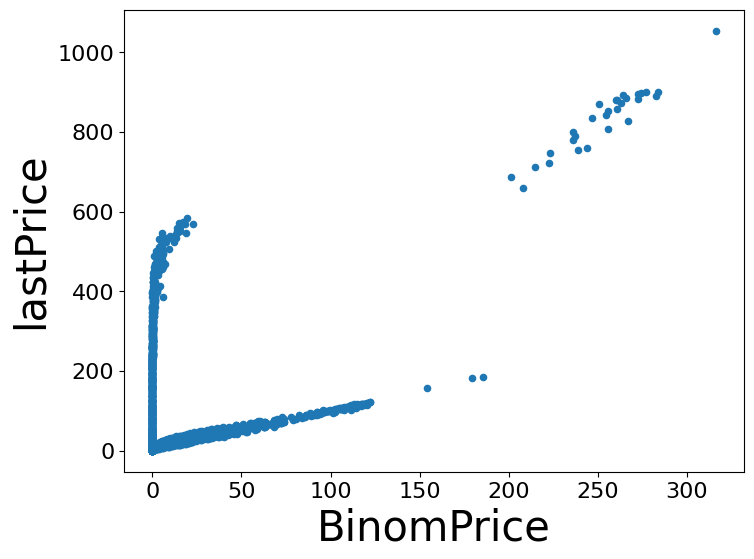

In [31]:
# Plot the results, we should see a stright line

df.plot.scatter(x="BinomPrice" ,y="lastPrice" )

Amb TSLA la cosa va diferent, tot i que hi ha un grup d'opcions que si que segueixen el preu predit per el mètode binomial, un altre grup es troba molt per damunt.
Això podria ser perquè TSLA ha estat un actiu que ha tingut fortes pujades de preu els darrers anys, i ha estat una acció molt popular. Pot ser per aquet motiu hi ha un gruix de gent important que ha "sobrevalorat" les opcions de compra.

# Exercise 2. Implement the Black-Scholes model

The Black-Scholes model is a mathematical model used to determine the fair value of a European call option. The model was first published in 1973 by Fischer Black and Myron Scholes. The model makes several assumptions about the market, such as that the underlying asset follows a lognormal distribution, the options are European, and markets are frictionless.

The value of a call option is calculated using the following formula:

$$ C(t, T) = Y(t)\mathcal{N}(d_1) - Ke^{-r(T-t)}\mathcal{N}(d_2) $$

Where:

* $C$ is the value of the call option
* $Y(t)$ is the current price of the underlying asset
* $K$ is the strike price of the option
* $r$ is the risk-free interest rate
* $T$ is the time to expiration in years
* $\sigma$ is the volatility of the underlying asset
* $\mathcal{N}(x)$ is the cumulative probability density function of the standard normal distribution
* $d_1, d_2$ are defined as:

$$ d_1 = \frac{ln(\frac{Y(t)}{K}) + (r + \frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}} $$

$$ d_2 = d_1 - \sigma\sqrt{T-t} $$

It's important to note that the Black-Scholes model makes certain assumptions about the market, such as the underlying asset follows a lognormal distribution and the options are European and markets are frictionless, so the results may not be accurate for all situations.

**1. Implement the Black-Scholes model**

In [12]:
from scipy.stats import norm

def black_scholes(t, S, K, T, r, sigma):
    time = T-t
    if time == 0: call = 0
    else:
      d_1 = (np.log(S/K) + (r+sigma**2/2.0)*(time))/(sigma*np.sqrt(time))
      d_2 = d_1 - sigma*np.sqrt(time)
      call = S*norm.cdf(d_1) - K*np.exp(-r*(time))*norm.cdf(d_2)

    return call

**2. Compute the price of an option with the given parameters using the Black-Scholes model and the binomial model (with both analytical and computational methods)**

 * I already give you this done

 * Plot the results for the values at different times. What do you observe?

<ipython-input-4-c57471c892b9>:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(n) / (np.math.factorial(n-i)*np.math.factorial(i))


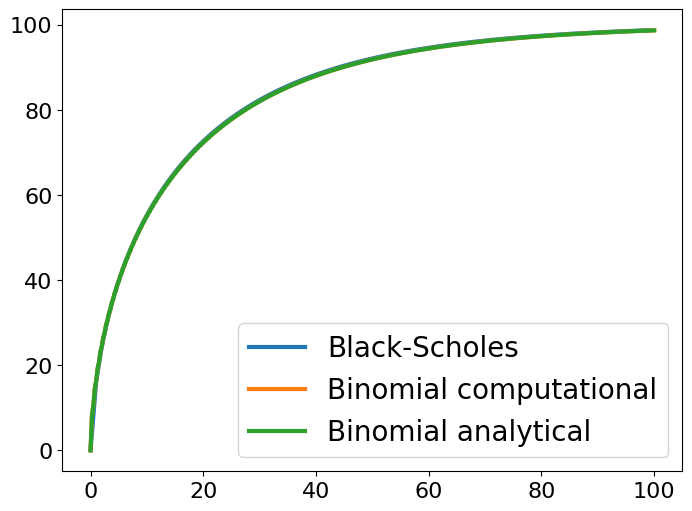

In [13]:
S = 100 #price of the underlying asset
K = 110 #strike price of the option
T = 100 #time to expiration
r = 0.0 #risk-free interest rate
sigma = 0.5 #volatility of the underlying asset
t = 0

#Time step
dt = 0.25

#Up and down price change factors
u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))

#Steps
steps = int(T/dt)

#Compute the fair prices for each step (N from 0 to steps) using the computational and analytical methods
C0_binom_comp = [call_price_binomial_computational(N, S, K, r, dt, u, d) for N in range(0, steps)]
C0_binom_anal = [call_price_binomial_analytical(N, S, K, r, dt, u, d) for N in range(0, steps)]
C0_BS = [black_scholes(t, S, K, T, r, sigma) for t in np.linspace(T, 0, 100)]


time_binom = np.linspace(0, T, steps)

plt.plot(C0_BS, lw=3, label="Black-Scholes")
plt.plot(time_binom, C0_binom_comp, lw=3, label="Binomial computational")
plt.plot(time_binom, C0_binom_anal, lw=3, label="Binomial analytical")

plt.legend()


**3. Repeat the previous step decreasing the time-step. Plot it for 4 different time steps, each one smaller than the previous one.**

  * What do you observe?

In [14]:
S = 100 #price of the underlying asset
K = 110 #strike price of the option
T = 100 #time to expiration
r = 0.0 #risk-free interest rate
sigma = 0.5 #volatility of the underlying asset
t = 0

time_step = [5,2,1,0.5]



<ipython-input-4-c57471c892b9>:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(n) / (np.math.factorial(n-i)*np.math.factorial(i))


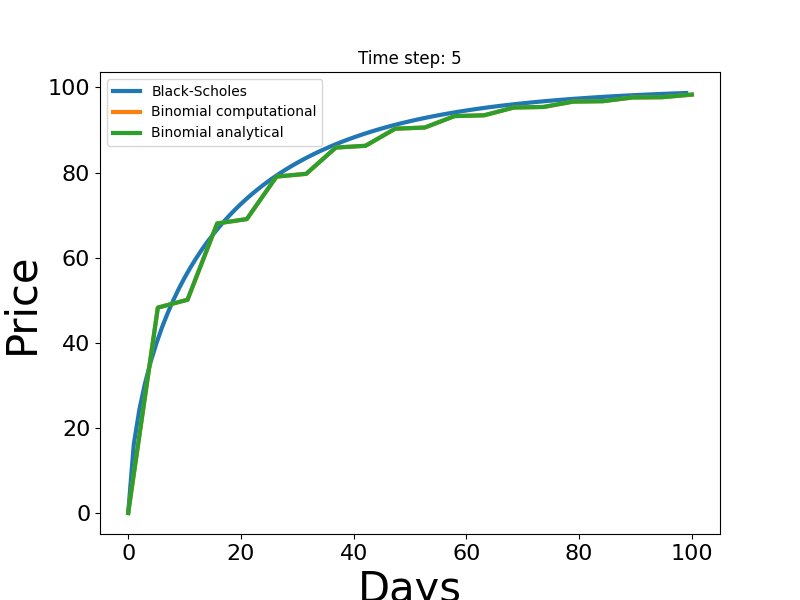

In [15]:
# We are going to create an animation to visualize the change in the model
from matplotlib.animation import FuncAnimation
rcParams["font.size"] = 10
def update(i):

  dt= time_step[i]

  #Up and down price change factors
  u = np.exp(sigma*np.sqrt(dt))
  d = np.exp(-sigma*np.sqrt(dt))

  #Steps
  steps = int(T/dt)

  #Compute the fair prices for each step (N from 0 to steps) using the computational and analytical methods
  C0_binom_comp = [call_price_binomial_computational(N, S, K, r, dt, u, d) for N in range(0, steps)]
  C0_binom_anal = [call_price_binomial_analytical(N, S, K, r, dt, u, d) for N in range(0, steps)]
  C0_BS = [black_scholes(t, S, K, T, r, sigma) for t in np.linspace(T, 0, 100)]

  time_binom = np.linspace(0, T, steps)

  plt.clf()
  plt.title(f'Time step: {dt}')
  plt.ylabel('Price')
  plt.xlabel('Days')


  plt.plot(C0_BS, lw=3, label="Black-Scholes")
  plt.plot(time_binom, C0_binom_comp, lw=3, label="Binomial computational")
  plt.plot(time_binom, C0_binom_anal, lw=3, label="Binomial analytical")

  plt.legend()

figure, ax = plt.subplots(figsize=(8, 6))


anim = FuncAnimation(figure,
                          func = update,
                          frames = 4,
                          interval=700,
                          )
anim.save("ani.gif")

plt.close()
from IPython.display import Image

Image(url='...')  # external
fname = '/content/ani.gif'
Image(open(fname, 'rb').read())  # local

A l'animació es veu perfectament com el mètode binomial convergeix al de Black-Scholes per intervals de temps cada cop més petits.